## Clustering

### 0. Data prep

Saving these in a separate py file for later

In [36]:
%%writefile data_utils.py

import pandas as pd
import re
import string
import nltk
from sklearn.model_selection import train_test_split
from nltk.corpus import stopwords
from datasets import load_dataset

nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

def preprocess_text(post):
    post = re.sub(r'\n', ' ', post)
    post = re.sub(r'[^\x00-\x7f]', '', post)
    post = post.lower().split()
    post = [word for word in post if word not in stop_words]
    post = [word for word in post if not word.startswith('http') and not word.startswith('@')]
    post = [word.translate(str.maketrans('', '', string.punctuation)) for word in post]
    post = [word for word in post if word]
    return post

def load_data(path):
    ds = load_dataset(path)
    df = ds['train'].to_pandas()
    df = df.dropna(subset=['body'])
    df = df[~df['body'].isin(['[removed]', '[deleted]'])].reset_index(drop=True)
    return df

def split_data(df, test_size=0.2, val_size=0.1, random_state=42):
    train_df, temp_df = train_test_split(df, test_size=(test_size + val_size), random_state=random_state)
    val_df, test_df = train_test_split(temp_df, test_size=test_size/(test_size + val_size), random_state=random_state)
    return train_df.reset_index(drop=True), val_df.reset_index(drop=True), test_df.reset_index(drop=True)

Overwriting data_utils.py


---

### 1. Baseline model

TF-IDF + KMeans clustering for different k:
- TF-IDF convert post to vector
- Kemans: 1000-d space, group based on euc distance
    - 1000 max_feature typically capture enough signal for medium length text
<br>

Reasons to choose this baseline:
- lightweight but strong methods
- No fancy modeling assumptions
- Comparable to LDA (that I plan to do later)

In [37]:
from data_utils import load_data, preprocess_text, split_data
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

# Load data, preprosessing
df = load_data("solomonk/reddit_mental_health_posts")
df['processed_body'] = df['body'].apply(preprocess_text)
df.head()

Repo card metadata block was not found. Setting CardData to empty.


,author,body,created_utc,id,num_comments,score,subreddit,title,upvote_ratio,url,processed_body
0,HotConversation1273,A few months ago I was accepted into this full...,2021-12-22T18:32:56.000Z,rmbjwb,1,1,ADHD,I get extremely anxious if I’m not working 24/7,1.0,https://www.reddit.com/r/ADHD/comments/rmbjwb/...,"[months, ago, accepted, full, time, software, ..."
1,snorefestt,"Hey guys, I was curious if anyone else has the...",2021-12-22T18:24:25.000Z,rmbd1y,3,5,ADHD,"I can't will myself to clean my own house, but...",1.0,https://www.reddit.com/r/ADHD/comments/rmbd1y/...,"[hey, guys, curious, anyone, else, issue, me, ..."
2,etyf12,\n\ni have 6 exams in the next 2 weeks one of...,2021-12-22T18:22:52.000Z,rmbbvu,1,2,ADHD,i need some help,1.0,https://www.reddit.com/r/ADHD/comments/rmbbvu/...,"[6, exams, next, 2, weeks, one, monday, havent..."
3,GetHairOrDieTryin,Is there anyone out there that is struggling w...,2021-12-22T18:20:35.000Z,rmba1t,3,2,ADHD,Anyone up for a chat?,1.0,https://www.reddit.com/r/ADHD/comments/rmba1t/...,"[anyone, struggling, addadhd, thats, interesti..."
4,ZeroTransPat,"Whenever I get hungry, I never eat because I d...",2021-12-22T18:18:47.000Z,rmb8lm,2,1,ADHD,Figuring out what to eat sucks,1.0,https://www.reddit.com/r/ADHD/comments/rmb8lm/...,"[whenever, get, hungry, never, eat, know, eat,..."


Technically if I'm just doing clustering, I don't need to check on unseen data. But I plan to explore supervised learning later so I will still split them (for clustering I will only use train data)

In [38]:
# Split into train, validation and test sets
train_df, val_df, test_df = split_data(df)
print(f"Train set: {len(train_df)}, Val set: {len(val_df)}, Test set: {len(test_df)}")

Train set: 104775, Val set: 14968, Test set: 29936


Evaluating different k to select the best one for LDA: 
<br><br>
**Silhouette score:** how well each datapoint fits within its assigned cluster
- (-1, 1); 1: perfect clustering; 0: borderline; -1: bad clustering
- We want it to be close to one
<br>

**WCSS (within cluster sum of sqs):** how compact the clusters are
- sum of sum of sq distances between each point
- We want it to be lower/closer to 0 -> more compact/tight

In [39]:
# Prepare training text for TF-IDF
train_texts = [' '.join(words) for words in train_df['processed_body']]

# Try different numbers of clusters
cluster_range = [5, 10, 15, 20]

tfidf_vectorizer = TfidfVectorizer(max_features=1000)
X_tfidf = tfidf_vectorizer.fit_transform(train_texts)

silhouette_scores = []
wcss_scores = []

for k in cluster_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(X_tfidf)
    sil_score = silhouette_score(X_tfidf, labels)
    wcss = kmeans.inertia_
    silhouette_scores.append(sil_score)
    wcss_scores.append(wcss)
    print(f"k={k} -> Silhouette Score: {sil_score:.4f}, WCSS: {wcss:.2f}")

/opt/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


k=5 -> Silhouette Score: 0.4216, WCSS: 55381.63


/opt/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


k=10 -> Silhouette Score: 0.4235, WCSS: 54382.46


/opt/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


k=15 -> Silhouette Score: 0.4237, WCSS: 53777.31


/opt/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


k=20 -> Silhouette Score: 0.4242, WCSS: 53400.63


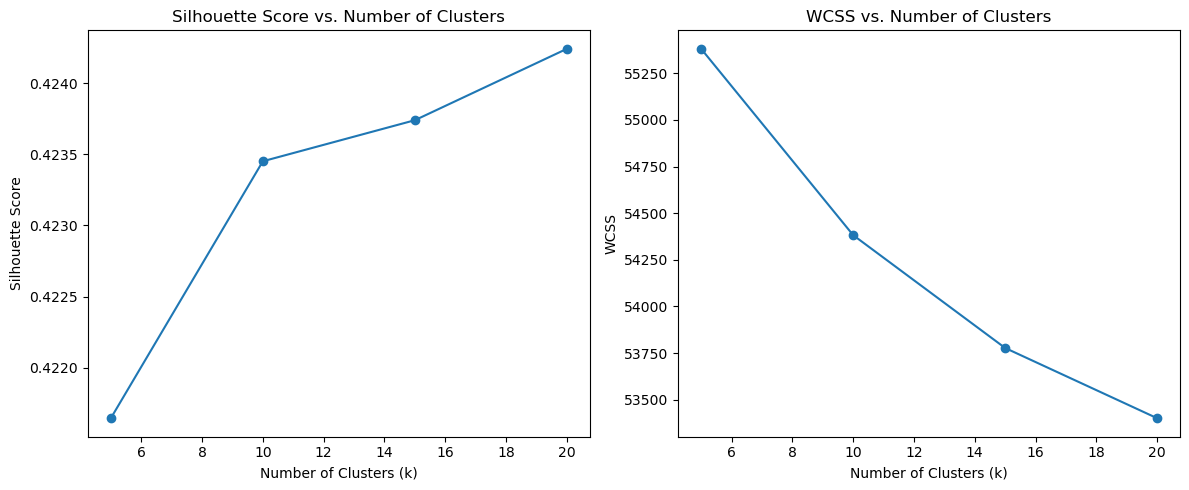

In [40]:
# Plot silhouette scores and WCSS
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(cluster_range, silhouette_scores, marker='o')
plt.title('Silhouette Score vs. Number of Clusters')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')

plt.subplot(1, 2, 2)
plt.plot(cluster_range, wcss_scores, marker='o')
plt.title('WCSS vs. Number of Clusters')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('WCSS')

plt.tight_layout()
plt.show()

Pretty bad results but it's not surprising since Reddit post data is noisy:
- Silhouette barely improves as k increases, WCSS decreases very slowly
- So the baseline is not good enough, and the posts have a lot of overlapping vocab
- Also tells us that increasing k won't help much

I will choose k=10 for LDA because:
- 5 are too few topics for a complicated theme
- But too many topics did not help, as seen in the results above
- So 10 is a reasonable middle ground
- Although Kmeans and LDA functions differently, but I mainly use k here to keep the comparison cohesive (that being said it's an important reminder)

Also here's a visualization for k=10 KMeans results (we can't visualize 1000-d so I used PCA to reduced it to 2-d), tho it probably looks even worse

/opt/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


[4 2 4 4 2 1 1 4 1 1]
[0.24614741 0.14454307]
Total variance explained: 0.3907


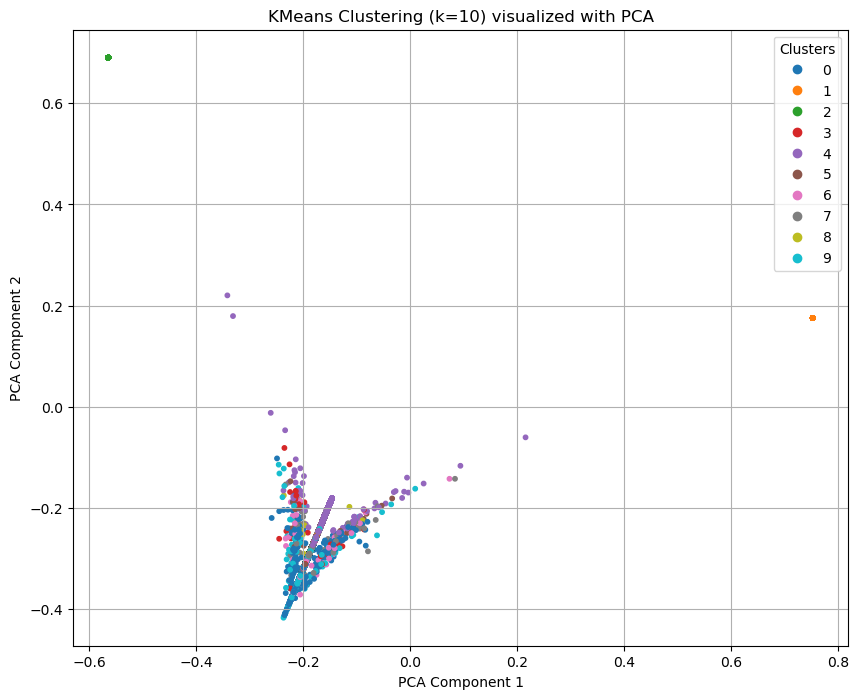

In [41]:
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

# Redo KMeans clustering
kmeans = KMeans(n_clusters=10, random_state=42)
kmeans_labels = kmeans.fit_predict(X_tfidf)
print(kmeans_labels[:10])  # Check first few labels

# Reduce dimensionality with PCA
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_tfidf.toarray())  # Note: X_tfidf needs to be dense (.toarray())
print(pca.explained_variance_ratio_)
print(f"Total variance explained: {sum(pca.explained_variance_ratio_):.4f}")

# Scatter plot colored by cluster
plt.figure(figsize=(10, 8))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=kmeans_labels, cmap='tab10', s=10)
plt.title('KMeans Clustering (k=10) visualized with PCA')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend(*scatter.legend_elements(), title="Clusters")
plt.grid(True)
plt.show()

---
### 2. LDA
**Latent Dirichlet Allocation**
- a probabilistic model used for topic modeling
- understand the "latent" or hidden structure of text by finding groups of words that frequently appear together in different documents

Why LDA?
- More soft (captures latent structures)
- More flexible (assuming each post belong partially to multiple topics)
- Therefore it's good for our messy and overlapping text data
- Also good visualizations!

In [42]:
# for LDA:
from pprint import pprint # Gensim
import gensim
import gensim.corpora as corpora
from gensim.models.ldamodel import LdaModel
from gensim.corpora import Dictionary
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
import pyLDAvis
import pyLDAvis.gensim_models
from gensim.test.utils import common_texts
from gensim.corpora.dictionary import Dictionary
from sklearn.model_selection import KFold
from itertools import product

In [52]:
dictionary = Dictionary(train_df['processed_body'])
corpus = [dictionary.doc2bow(post) for post in train_df['processed_body']]

lda = LdaModel(
               corpus=corpus,
               id2word=dictionary,
               num_topics=10, # k=10 as previously discussed
               alpha="auto", # Prior on document-topic distribution
               eta="auto", # Prior on topic-word distribution
               random_state=42,
               passes=5,
               iterations=100)

print("Topics discovered by LDA model:")
pprint(lda.print_topics(num_words=10))

Topics discovered by LDA model:
[(0,
  '0.009*"room" + 0.007*"one" + 0.007*"back" + 0.007*"hands" + 0.006*"like" + '
  '0.006*"house" + 0.006*"get" + 0.006*"got" + 0.006*"car" + 0.005*"go"'),
 (1,
  '0.018*"life" + 0.015*"like" + 0.011*"even" + 0.010*"things" + 0.009*"time" '
  '+ 0.009*"feel" + 0.009*"it" + 0.009*"me" + 0.008*"want" + 0.008*"know"'),
 (2,
  '0.020*"work" + 0.019*"get" + 0.017*"time" + 0.016*"day" + 0.011*"sleep" + '
  '0.010*"like" + 0.009*"hours" + 0.008*"need" + 0.008*"days" + 0.007*"cant"'),
 (3,
  '0.053*"im" + 0.041*"like" + 0.035*"feel" + 0.027*"dont" + 0.022*"know" + '
  '0.019*"want" + 0.017*"ive" + 0.016*"cant" + 0.015*"really" + 0.014*"get"'),
 (4,
  '0.046*"adhd" + 0.034*"school" + 0.014*"diagnosed" + 0.012*"diagnosis" + '
  '0.012*"get" + 0.011*"college" + 0.011*"class" + 0.009*"symptoms" + '
  '0.008*"high" + 0.008*"year"'),
 (5,
  '0.013*"years" + 0.010*"got" + 0.010*"time" + 0.009*"back" + 0.009*"year" + '
  '0.008*"job" + 0.008*"months" + 0.007*"last" 

In [53]:
# a measure of how good the model is - the lower the better
print('\nPerplexity: ', lda.log_perplexity(corpus))


Perplexity:  -8.10853901584718


Not that good, but reasonable?

In [54]:
# Visualization
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda, dictionary=dictionary, corpus=corpus)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1      0.143296  0.042567       1        1  20.359736
3      0.166106  0.063681       2        1  18.631408
5     -0.037870 -0.147623       3        1  13.457955
7     -0.012924  0.184756       4        1  11.320842
2     -0.004037 -0.024222       5        1   8.371035
6      0.053628 -0.060910       6        1   7.532371
0      0.111712 -0.184397       7        1   6.611964
9      0.022131  0.134512       8        1   5.960499
4     -0.174290 -0.014212       9        1   4.383539
8     -0.267752  0.005849      10        1   3.370649, topic_info=           Term          Freq         Total Category  logprob  loglift
23           im  55245.000000  55245.000000  Default  30.0000  30.0000
479         ocd  21231.000000  21231.000000  Default  29.0000  29.0000
267        dont  26994.000000  26994.000000  Default  28.0000  28.0000
98     thoughts  16231.000000  16231.000000  Default  27.0000  27.0000
831        adhd  16877.000000  16877.000000  Default  26.0000  26.0000
..          ...           ...           ...      ...      ...      ...
746  depression   1083.048966   7840.621840  Topic10  -5.1308   1.4105
3          also   1225.420110  20069.276821  Topic10  -5.0073   0.5942
361         ago   1071.749487   8731.166525  Topic10  -5.1413   1.2925
92        since    979.203095  13789.624874  Topic10  -5.2316   0.7451
103       tried    920.527157   7319.612195  Topic10  -5.2934   1.3167

[837 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
1947     10  0.998293      10mg
5702      5  0.995825      18mg
1848      1  0.014650         2
1848      2  0.008643         2
1848      3  0.472018         2
...     ...       ...       ...
1590      1  0.895711  yourself
1590      4  0.093303  yourself
1590      8  0.009330  yourself
4388      8  0.010374    zoloft
4388     10  0.988525    zoloft

[2536 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 4, 6, 8, 3, 7, 1, 10, 5, 9])

Not doing hyperparameter tuning here (taking too much time, but I have the code in `lda_hyperparams_tuning.py` for reference), directly moving into result interpretation

After inspecting the top keywords of each topic discovered by the final LDA model, the following interpretations are assigned:

| Topic ID | Top Keywords | Interpretation |
|:---|:---|:---|
| 0 | room, one, back, hands, house, car, go | **Daily Environment and Activities** (references to physical spaces and movement). |
| 1 | life, like, even, things, time, feel, want, know | **General Life Struggles and Emotional Reflections**. |
| 2 | work, get, time, day, sleep, hours, need, days | **Work, Daily Routine, and Sleep Issues**. |
| 3 | im, like, feel, dont, know, want, ive, cant, really, get | **Personal Emotional Distress** (highly personal posts about feeling lost or struggling). |
| 4 | adhd, school, diagnosed, diagnosis, get, college, class, symptoms, high, year | **ADHD Diagnosis and School/Academic Challenges**. |
| 5 | years, got, time, back, year, job, months, last, since, going | **Timeline Narratives (Job and Life Changes Over Years)**. |
| 6 | ptsd, me, would, trauma, happened, felt, never, said, remember | **PTSD, Trauma, and Emotional Memory**. |
| 7 | people, also, like, anyone, would, lot, social, find, something, things | **Social Interaction and Connection Challenges**. |
| 8 | medication, meds, taking, take, adderall, doctor, adhd, anxiety, dose, effects | **Medication Management (Primarily ADHD and Anxiety Medications)**. |
| 9 | ocd, thoughts, intrusive, anxiety, thought, like, something, think, fear, anyone | **OCD and Intrusive Thoughts with Anxiety**.


- **Specific and Strong Topics**:
  - Topics 4, 6, 8, and 9 are clearly focused on specific clinical conditions (ADHD, PTSD, Medication, OCD).
  - Topic 2 and 3 represent routine and emotional struggles respectively and are distinct but common in mental health communities.
  - Topic 7 reflects **social struggles**, important in mental health contexts.

- **Vague Topics**:
  - Topic 1 is broader ("life", "things", "feel"), capturing general emotional distress without anchoring to a specific issue.
  - Topic 5 (timeline narratives) is centered on life events over time (e.g., jobs, years), moderately specific.

- **Broad Personal Contexts**:
  - Topic 0 discusses everyday environments (house, room, car), which could overlap across various mental health experiences.

Now attaching these topics back to my train_df:
- First need to select the dominant topic for each document
- Add as train_df['dominant_topic']
- Create mapping

In [88]:
# Assign dominant topic
train_doc_topics = []
for bow in corpus:  
    topic_dist = lda_model.get_document_topics(bow)
    dominant_topic = max(topic_dist, key=lambda x: x[1])[0]
    train_doc_topics.append(dominant_topic)

train_df['dominant_topic'] = train_doc_topics
train_df = train_df[~train_df['body'].isin(['[removed]', '[deleted]'])].reset_index(drop=True)

# Mapping
topic_label_map = {
    0: "Daily Life Challenges (Environment and Activities)",
    1: "General Emotional Struggles and Reflections",
    2: "Daily Life Challenges (Work, Sleep, Routine)",
    3: "Personal Emotional Distress",
    4: "ADHD and Academic Challenges",
    5: "Timeline Narratives (Job, Life Changes)",
    6: "PTSD and Trauma Experiences",
    7: "Social Interaction Challenges",
    8: "Medication Management (ADHD/Anxiety)",
    9: "OCD and Intrusive Thoughts"
}

# Apply mapping
train_df['topic_label'] = train_df['dominant_topic'].map(topic_label_map)

# Check first few rows
train_df[['body', 'dominant_topic', 'topic_label']].head()


,body,dominant_topic,topic_label
0,"I was recently diagnosed with PTSD, and I’m re...",2,"Daily Life Challenges (Work, Sleep, Routine)"
1,"Hello, i have a rather strange post-traumatic ...",6,PTSD and Trauma Experiences
2,"My high school is a ""self directed"" program wi...",7,Social Interaction Challenges
3,I woke up today in a puddle of sweat from nigh...,4,ADHD and Academic Challenges
4,I’m 23 years old living with my kinda close fr...,5,"Timeline Narratives (Job, Life Changes)"


In [89]:
train_df[['body', 'dominant_topic', 'topic_label']].to_csv('labeled_data.csv', index=False)

----
### 3. Result intepretation

Created a new dataset with posts and topic labels (generated by both clustering + human interpretation of the clustering). Now take a look at the result dataset "labeled_data.csv":

In [90]:
# Load again
labeled_df = pd.read_csv('labeled_data.csv')

# Overview
print("Shape of the dataset:", labeled_df.shape)
display(labeled_df.head())

# Topic distribution
print("\nTopic distribution (by ID):")
display(labeled_df['dominant_topic'].value_counts())

print("\nTopic distribution (by label):")
display(labeled_df['topic_label'].value_counts())

# Text length stats
labeled_df['text_length'] = labeled_df['body'].apply(lambda x: len(x.split()))
print("\nAverage text length:", labeled_df['text_length'].mean())
print("Median text length:", labeled_df['text_length'].median())

Shape of the dataset: (60872, 3)


,body,dominant_topic,topic_label
0,"I was recently diagnosed with PTSD, and I’m re...",2,"Daily Life Challenges (Work, Sleep, Routine)"
1,"Hello, i have a rather strange post-traumatic ...",6,PTSD and Trauma Experiences
2,"My high school is a ""self directed"" program wi...",7,Social Interaction Challenges
3,I woke up today in a puddle of sweat from nigh...,4,ADHD and Academic Challenges
4,I’m 23 years old living with my kinda close fr...,5,"Timeline Narratives (Job, Life Changes)"



Topic distribution (by ID):


dominant_topic
5    27694
2    11113
6     6577
4     5967
8     4611
7     3032
0     1353
3      370
1       88
9       67
Name: count, dtype: int64


Topic distribution (by label):


topic_label
Timeline Narratives (Job, Life Changes)               27694
Daily Life Challenges (Work, Sleep, Routine)          11113
PTSD and Trauma Experiences                            6577
ADHD and Academic Challenges                           5967
Medication Management (ADHD/Anxiety)                   4611
Social Interaction Challenges                          3032
Daily Life Challenges (Environment and Activities)     1353
Personal Emotional Distress                             370
General Emotional Struggles and Reflections              88
OCD and Intrusive Thoughts                               67
Name: count, dtype: int64


Average text length: 180.96229793665395
Median text length: 125.0


/var/folders/v1/nddck6795bscz6d99m4_w0vr0000gn/T/ipykernel_81786/4081087911.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=train_df, y='topic_label', order=train_df['topic_label'].value_counts().index, palette="viridis")


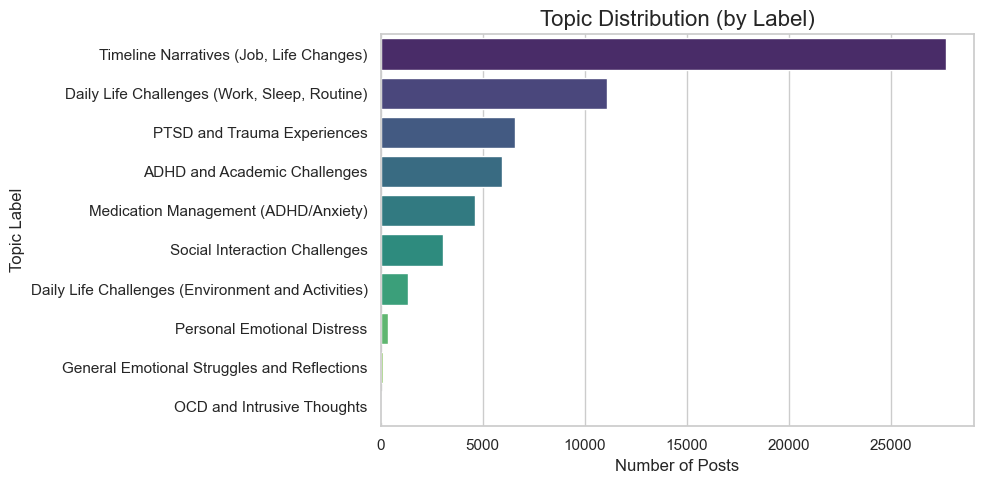

In [91]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")

# Bar Plot: Topic distribution by Label
plt.figure(figsize=(10,5))
sns.countplot(data=train_df, y='topic_label', order=train_df['topic_label'].value_counts().index, palette="viridis")
plt.title('Topic Distribution (by Label)', fontsize=16)
plt.xlabel('Number of Posts')
plt.ylabel('Topic Label')
plt.tight_layout()
plt.show()


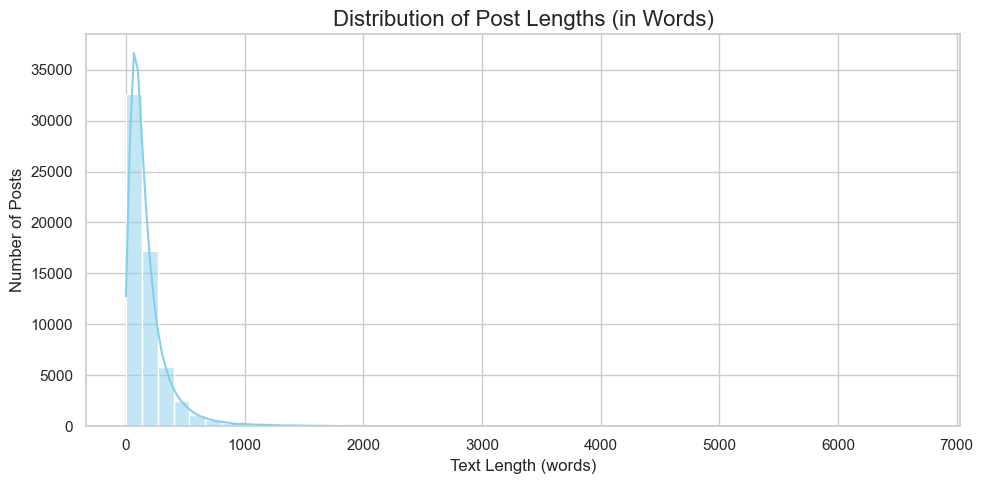

In [92]:
# Histogram: Text length distribution
plt.figure(figsize=(10,5))
sns.histplot(train_df['body'].apply(lambda x: len(x.split())), bins=50, kde=True, color="skyblue")
plt.title('Distribution of Post Lengths (in Words)', fontsize=16)
plt.xlabel('Text Length (words)')
plt.ylabel('Number of Posts')
plt.tight_layout()
plt.show()

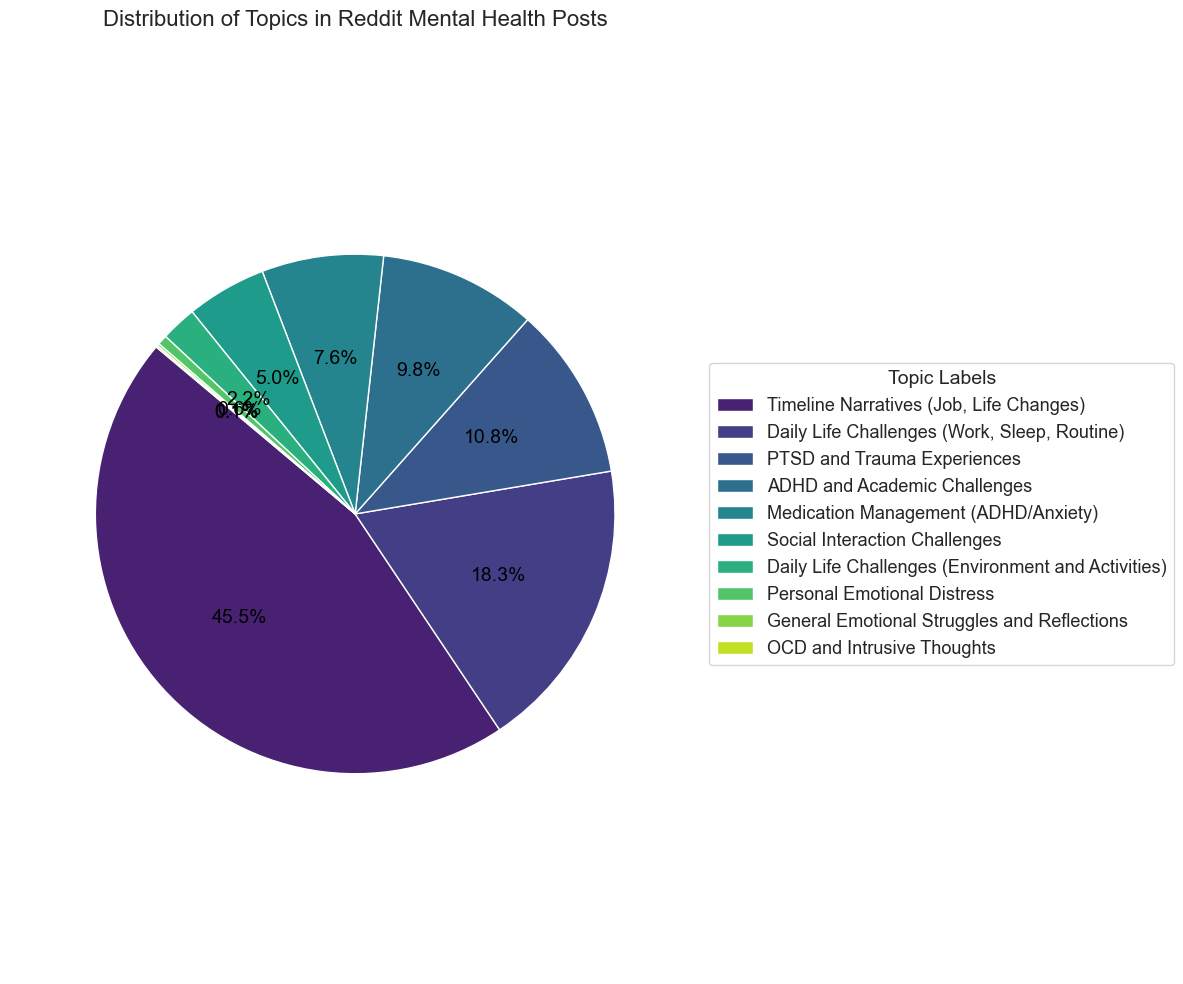

In [93]:
# Pie chart

topic_counts = train_df['topic_label'].value_counts()
colors = colors=sns.color_palette('viridis', len(topic_counts))

fig, ax = plt.subplots(figsize=(12, 10))

wedges, texts, autotexts = ax.pie(
    topic_counts,
    autopct='%1.1f%%',
    startangle=140,
    colors=colors,
    textprops=dict(color="black", fontsize=14)
)

ax.legend(
    topic_counts.index,
    title="Topic Labels",
    loc="center left",
    bbox_to_anchor=(1, 0.5),
    fontsize=13,
    title_fontsize=14
)

ax.axis('equal')

plt.title('Distribution of Topics in Reddit Mental Health Posts', fontsize=16, pad=20)
plt.tight_layout()
plt.show()
